<a href="https://colab.research.google.com/github/SASambath69/notebooks/blob/main/Analyse_des_Messages_d'un_Groupe_WhatsApp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objectifs

Le pr√©sent notebook a √©t√© r√©alis√© pour effectuer une analyse des discussions d'un groupe WhatsApp. Les informations concernant les exp√©diteurs seront anonymis√©es. Les objectifs seront les suivants :

*    A quel moment de la journ√©e et quel jour de la semaine il y a le plus de messages ?
*    Quelles sont les contributions des membres du groupe (classement par nombre de messages envoy√©s) ?
*    Quels sont les 20 mots les plus utilis√©s (au global, puis par les 5 personnes qui envoient le plus de messages) ?
*    Quels sont les emojis les plus pr√©sents ?

# Import des Librairies

Petites pr√©cisions sur quelques librairies utilis√©es :

*    nltk : pour l'analyse des mots contenus dans les messages
*    string : servira pour retirer les ponctuations lors de l'analyse des mots
*    emoji : pour l'analyse des emojis les plus utils√©s
*    InteractiveShell : pour afficher tous les outputs d'un bloc de code, et ne pas se limiter au dernier output
*    drive : pour me connecter √† mon Google Drive et r√©cup√©rer le fichier txt correspondant √† la sauvegarde de la discussion WhatsApp

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('popular')
import string
!pip install emoji
import emoji
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

# Import et Retraitement du fichier contenant les discussions

Par d√©faut, les discussions vont √™tre retranscris dans un DataFrame √† 1 colonne. Les retraitements et travaux seront les suivants :

1.    Identification des lignes qui correspondent √† des suites de messages. En effet, selon la longueur des messages, ceux-ci peuvent appara√Ætre sur plusieurs lignes du DataFrame. L'objectif est ainsi de les rep√©rer selon diff√©rents moyens (longueur du texte inf√©rieur √† un certain nombre ou absence de date dans les 1ers caract√®res du message) puis de les replacer √† la suite des messages dont ils correspondent
2.    Cr√©ation d'une colonne contenant la date et heure de l'envoi du message
3.    Cr√©ation d'une colonne contenant le nom de l'exp√©diteur et anonymisation
4.    Cr√©ation de 2 colonnes correspondant au jour de la semaine (de 1 √† 7) et √† l'heure de la journ√©e (de 0 √† 23), puis pivot table pour afficher le nombre de messages envoy√©s par heure de la jour et par jour de la semaine
5.    Cr√©ation d'une colonne contenant le message
6.    Identification des mots les plus utilis√©s (ajout de certains mots, expressions, caract√®res √† la liste des stopwords). Pour les messages contenant des m√©dias, ceux-ci apparaissent avec la mention "<M√©dias omis>". Je d√©cide de ne pas en tenir compte
7.    Identification des mots les plus utilis√©s par les 5 personnes qui envoient le plus de message
8.    Identification des emojis les plus utilis√©s

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Discussion WhatsApp.txt', delimiter = "\t", header = None, names = ['text'])

# ------------------------------ Identification des lignes correspondant √† des suites de message et replacement de ces derniers √† la suite des messages auxquels ils appartiennent

df['follow_message'] = df['text'].apply(lambda x: True if len(x) < 10 else (True if x[2] != '/' else False))
df['text_def'] = df['text']
for i in range(len(df['text'])):
  if i != len(df['text'])-1 and df['follow_message'][i] == False and df['follow_message'][i+1] == False:
    pass
  elif df['follow_message'][i] == True:
    start = i
    while df['follow_message'][start] == True:
      df['text_def'][i-1] = df['text_def'][i-1] + ' ' + df['text_def'][start]
      start += 1

df = df.loc[df['follow_message'] == False].drop(columns=['text','follow_message'])

# ------------------------------ Extraction des dates et heures

df[['datetime_str','no_date']] = df["text_def"].str.split(' - ', 1, expand=True)
df['datetime_str'] = df['datetime_str'].str.replace(' √†', '')
df['datetime_str'] = pd.to_datetime(df['datetime_str'])

# ------------------------------ Extraction des exp√©diteurs

df = df.loc[df['no_date'].str.contains(':')==True]
df[['sender','text_message']] = df['no_date'].str.split(': ', 1, expand=True)

# ------------------------------ Anonymisation

senders = list(df['sender'].unique())
anonyme = []
for i in range(len(df['sender'].unique())):
  anonyme.append('sender_{}'.format(i+1))
df['sender'] = df['sender'].replace(senders, anonyme)

# ------------------------------ Cr√©ation de colonnes "day_of_week" et "hour_of_day" pour le Heatmap

df['day_of_week'] = df['datetime_str'].dt.dayofweek + 1
df['hour_of_day'] = df['datetime_str'].dt.hour
heatmap_df = df.pivot_table(index='day_of_week', columns='hour_of_day', values='text_message', aggfunc='count')

# ------------------------------ Rep√©rer les mots les plus utilis√©s

stop_words = list(stopwords.words('french'))
stop_words.extend(['a','‚Äô','je','√ßa','ca','c','j','et','...'])

all_words = ''

# Certains messages correspondent en r√©alit√© √† des m√©dias et sont inscrits "<M√©dias omis>". On n'en tient pas compte pour la suite
for i in df['text_message'].loc[df['text_message'].str.lower().str.contains('m√©dias omis')==False]:
  all_words = all_words + ' ' + i

df_words = pd.DataFrame({'words' : word_tokenize(all_words)})
df_words['no_stop_words'] = df_words['words'].apply(lambda x: x.lower() if x.lower() not in stop_words and x.lower() not in list(string.punctuation) else np.NaN)

df_top_words = pd.DataFrame({'words' : list(df_words['no_stop_words'].value_counts().head(20).index),
                                  'count' : list(df_words['no_stop_words'].value_counts().head(20).values)})

# ------------------------------ Mots les plus utilis√©s par exp√©diteur (top 5 des exp√©diteurs)

df_by_sender = pd.DataFrame()

for i in range(5):
  sender = df['sender'].value_counts().head(5).index[i]
  df_sender = df.loc[df['sender'] == sender].loc[df['text_message'].str.lower().str.contains('m√©dias omis')==False]
  all_words_sender = ''
  for j in df_sender['text_message']:
    all_words_sender = all_words_sender + ' ' + j
  df_words_sender = pd.DataFrame({'sender' : sender, 'words' : word_tokenize(all_words_sender)})
  df_words_sender['no_stop_words'] = df_words_sender['words'].apply(lambda x: x.lower() if x.lower() not in stop_words and x.lower() not in list(string.punctuation) else np.NaN)
  df_words_sender_top = pd.DataFrame({'sender' : sender, 'words' : list(df_words_sender['no_stop_words'].value_counts().head(20).index), 'count' : list(df_words_sender['no_stop_words'].value_counts().head(20).values)})

  df_by_sender = pd.concat([df_by_sender, df_words_sender_top], axis = 0)

# ------------------------------ Top 10 des emojis

df_words['emoji'] = df_words['no_stop_words'].apply(lambda x: x if x in emoji.UNICODE_EMOJI and x != '\U0001f3fc' else np.NaN)

df_top_emoji = pd.DataFrame({'emoji' : list(df_words['emoji'].value_counts().head(10).index), 'count' : list(df_words['emoji'].value_counts().head(10).values)})

# A quel moment de la journ√©e et quel jour de la semaine il y a le plus de messages ?

Text(0.5, 0, 'Hour of Day')

Text(0, 0.5, 'Day of Week')

Text(0.5, 1.0, 'Nombre de messages envoy√©s par heure de la journ√©e et par jour de la semaine')

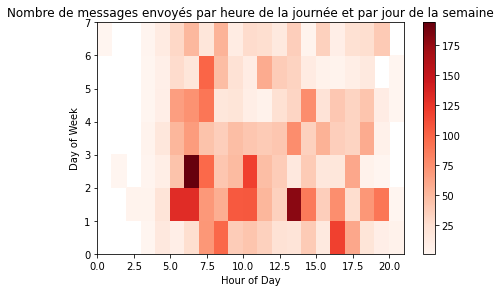

In [ ]:
# Heatmap
plt.pcolor(heatmap_df, cmap='Reds')
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.colorbar()
plt.tight_layout()
plt.title('Nombre de messages envoy√©s par heure de la journ√©e et par jour de la semaine')
plt.show()

Les moments o√π les messages sont les plus envoy√©s sont :
*    en d√©but de journ√©e (entre 5h et 8h) et d√©but d'apr√®s-midi (vers 13h)
*    plut√¥t en d√©but de semaine (Mardi et Mercredi)

# Quelles sont les contributions des membres du groupe (classement par nombre de messages envoy√©s) ?

In [ ]:
# Histogram
fig = px.histogram(data_frame=df, x='sender').update_xaxes(categoryorder='total descending')
fig.update_layout(title = 'Contribution des membres', title_x = 0.5)

Un membre particuli√®rement tr√®s actif par rapport aux autres

# Quels sont les 20 mots les plus utilis√©s (au global, puis par les 5 personnes qui envoient le plus de messages) ?

In [ ]:
fig = px.bar(data_frame = df_top_words,
       x = 'words',
       y = 'count')
fig.update_layout(title = 'Top 20 des mots / expressions / etc... utilis√©s', title_x = 0.5)

In [ ]:
fig = px.bar(data_frame = df_by_sender.iloc[:20,:], x = 'words', y = 'count')
fig.update_layout(title = 'Mots les plus utilis√©s par {}'.format(df['sender'].value_counts().head(5).index[0]), title_x = 0.5)

In [ ]:
fig = px.bar(data_frame = df_by_sender.iloc[20:40,:], x = 'words', y = 'count')
fig.update_layout(title = 'Mots les plus utilis√©s par {}'.format(df['sender'].value_counts().head(5).index[1]), title_x = 0.5)

In [ ]:
fig = px.bar(data_frame = df_by_sender.iloc[40:60,:], x = 'words', y = 'count')
fig.update_layout(title = 'Mots les plus utilis√©s par {}'.format(df['sender'].value_counts().head(5).index[2]), title_x = 0.5)

In [ ]:
fig = px.bar(data_frame = df_by_sender.iloc[60:80,:], x = 'words', y = 'count')
fig.update_layout(title = 'Mots les plus utilis√©s par {}'.format(df['sender'].value_counts().head(5).index[3]), title_x = 0.5)

In [ ]:
fig = px.bar(data_frame = df_by_sender.iloc[80:100,:], x = 'words', y = 'count')
fig.update_layout(title = 'Mots les plus utilis√©s par {}'.format(df['sender'].value_counts().head(5).index[4]), title_x = 0.5)

# Quels sont les emojis les plus pr√©sents ?

In [ ]:
px.bar(data_frame=df_top_emoji, x='emoji', y='count')
df_top_emoji

emoji  count
0     ü§£    111
1     üëç     97
2     üòÇ     88
3     üòÅ     53
4     üòâ     32
5     üòä     24
6     üò±     22
7     üòÖ     20
8     ü§î     16
9     üôÇ     16

Dans ce groupe, d'abord on est de bonne humeur et on rigole, ensuite on panique, et √† la fin seulement on r√©fl√©chit mdr